# Chavas (2015) profile fit on SAR data
The SAR data grid is already centered on the TC center found by the method of Léo.

We use a Chavas wind profile, as presented by Chavas et al. in their paper of 2015. Inner and outer solutions are defined by implicit equations that are solved numerically to fit on the observations. Thus, we conduct the fitting in 2 steps:


1) We first fit the inner solution;


2) Given the Rmax and Vmax that were found previously, we determine the merge point and fit the outer solution.


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import griddata
from scipy.optimize import curve_fit
from scipy.integrate import odeint

import functions as f

In [2]:
### PATHS
# dir_path  = '/home/arthur/data/cyclobs/ggd/'
dir_path  = '/home/arthur/data/cyclobs/rotated_files/'
file_path = 's1b-iw-owi-cm-20170923t104349-20170923t104554-000003-00D45F_ll_gd_rotated.nc'
# file_path = 'rs2--owi-cm-20120928t095127-20120928t095327-00003-BDBE0_ll_gd_rotated.nc'
# NAN BUG (because no wind speed value after r = 400 km, we have to stop the dataset there) file_path = 'rs2--owi-cm-20130701t104119-20130701t104235-00003-79BFE_ll_gd_rotated.nc'
# file_path = 's1a-ew-owi-cm-20180201t132219-20180201t132527-000003-022E2F_ll_gd_rotated.nc'

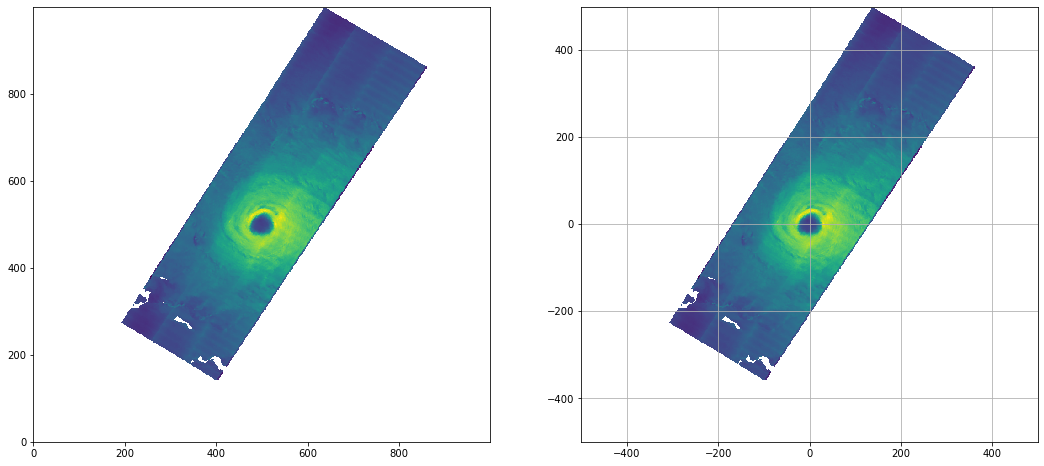

In [3]:
### OPEN AND PRINT
ds = xr.open_dataset(dir_path + file_path)
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.pcolormesh(ds['x'], ds['y'], ds['wind_speed'])
plt.subplot(1, 2, 2)
plt.pcolormesh(ds['x_coords'], ds['y_coords'], ds['wind_speed']);plt.grid()

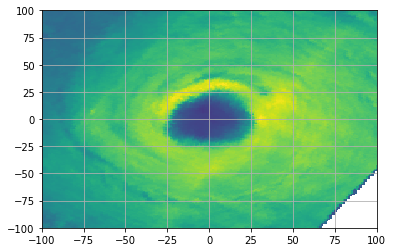

In [4]:
### TEST
plt.pcolormesh(ds['x_coords'], ds['y_coords'], ds['wind_speed'])
plt.axis([-100,100,-100,100]);plt.grid()

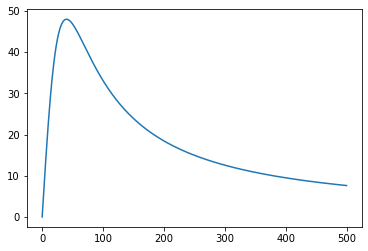

In [5]:
### DEFINE INNER PROFILE FUNCTION
def chavas_inner_profile(r, Rmax, Vmax):
    '''We assume that Ck/Cd = 1'''
    fcor       = f.coriolis(20)
    CkCd_ratio = 1. 
    
    M   = r * 0.
    Mm  = Rmax * Vmax + 0.5 * fcor * Rmax ** 2
    M   = Mm * (2 * (r / Rmax) ** 2 / (2 - CkCd_ratio + CkCd_ratio * (r / Rmax) ** 2)) ** (1 / (2 - CkCd_ratio))
    
    V   = (M / r) - 0.5 * fcor * r
    return V

# Print the shape
r = np.arange(501) + 0.001 # To avoid dividing by zero
V = chavas_inner_profile(r, Rmax=40, Vmax=48) 
plt.plot(r, V)

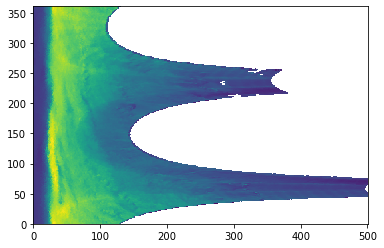

In [6]:
### DEFINE (r, theta) GRID
r     = np.arange(501)
th    = np.arange(361)
r, th = np.meshgrid(r, th)
ds_r  = np.array(ds['r_polar'])

ds_th = np.mod(np.array(ds['theta']) * 180. / np.pi, 360) # convert theta from radians to degrees
ds_ws = np.array(ds['wind_speed'])
# Possible to call griddata() without using meshgrid() before? 
spd   = griddata((ds_r.flatten(), ds_th.flatten()), ds_ws.flatten(), (r, th), method='nearest')

plt.pcolormesh(spd)

Initialization values ==> 32 ,  46.73
Final values ========> [57.91 43.17]


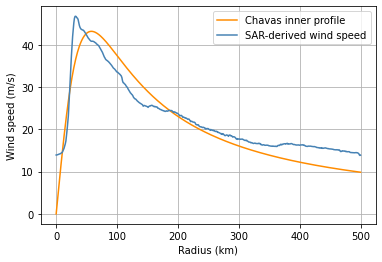

In [7]:
### FITTING THE INNER PROFILE
# Initializing the values
radius = np.arange(501) + .0001 # to avoid having both r = 0 and n < 0 during fitting process
spdm   = np.nanmean(spd, axis=0)
Rmax   = np.argmax(spdm[:100]) # 40
Vmax   = np.max(spdm[:100]) # 48

# Fit profile to data
print("Initialization values ==>", Rmax, ", ", "{:.2f}".format(Vmax))
popt, pcov = curve_fit(chavas_inner_profile, radius, spdm, [Rmax, Vmax])
print("Final values ========>", np.around(popt, decimals=2)) # Caveat: Real VMAX = Vmax + Vmin

# Print the results
V_fit = chavas_inner_profile(radius, popt[0], popt[1])
fig1  = plt.plot(radius, V_fit, color='darkorange', label='Chavas inner profile')    # V_fit
fig2  = plt.plot(radius, spdm,  color='steelblue',  label='SAR-derived wind speed')  # V_obs
plt.xlabel('Radius (km)')
plt.ylabel('Wind speed (m/s)')
plt.legend();plt.grid()

[   0   -1   -2   -3   -4   -5   -6   -7   -8   -9  -10  -11  -12  -13
  -14  -15  -16  -17  -18  -19  -20  -21  -22  -23  -24  -25  -26  -27
  -28  -29  -30  -31  -32  -33  -34  -35  -36  -37  -38  -39  -40  -41
  -42  -43  -44  -45  -46  -47  -48  -49  -50  -51  -52  -53  -54  -55
  -56  -57  -58  -59  -60  -61  -62  -63  -64  -65  -66  -67  -68  -69
  -70  -71  -72  -73  -74  -75  -76  -77  -78  -79  -80  -81  -82  -83
  -84  -85  -86  -87  -88  -89  -90  -91  -92  -93  -94  -95  -96  -97
  -98  -99 -100 -101 -102 -103 -104 -105 -106 -107 -108 -109 -110 -111
 -112 -113 -114 -115 -116 -117 -118 -119 -120 -121 -122 -123 -124 -125
 -126 -127 -128 -129 -130 -131 -132 -133 -134 -135 -136 -137 -138 -139
 -140 -141 -142 -143 -144 -145 -146 -147 -148 -149 -150 -151 -152 -153
 -154 -155 -156 -157 -158 -159 -160 -161 -162 -163 -164 -165 -166 -167
 -168 -169 -170 -171 -172 -173 -174 -175 -176 -177 -178 -179 -180 -181
 -182 -183 -184 -185 -186 -187 -188 -189 -190 -191 -192 -193 -194 -195
 -196 

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-30-4ca5694a452b>:22: RuntimeWarning: invalid value encountered in true_divide
  Vtest = M / radius - 0.5 * f.coriolis(20) * radius


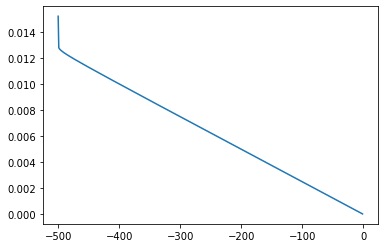

In [30]:
### DEFINE OUTER PROFILE FUNCTION
chi = 1.0 # TO DEFINE
r0  = 500. # TO DEFINE

def dM_dr(M, r, r0, chi):
    "Differential equation in M, with r as the integration step."
    fcor  = f.coriolis(20)
    dM_dr = chi * (M - (0.5 * fcor * r ** 2)) ** 2 / (r0 ** 2 - r ** 2)
    return dM_dr

# SOLVE THE EQUATION USING Ma = M(Ra)!!!
# Look at the code given by Chavas
radius = np.arange(-500, 1, 1)
radius = radius[::-1]
print(radius)
M = odeint(dM_dr, 0, radius, args=(r0, chi)) # in r = 0 we have M = 0
print("SHAPE BEFORE:", M.shape)
M = np.reshape(M, -1)
print("SHAPE After:", M.shape)
# plt.plot(radius, M)

Vtest = M / radius - 0.5 * f.coriolis(20) * radius
plt.plot(radius, Vtest)
print(Vtest.shape)

def chavas_outer_profile(r, r0, chi, Vmax):
    '''We assume that Ck/Cd = 1'''
    Omega      = 7.2921e-5                            # Earth rotation vector
    f          = 2 * Omega * np.sin(20 * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant
    CkCd_ratio = 1. 
    
    M   = r * 0.
    Mm  = Rmax * Vmax + 0.5 * f * Rmax ** 2
    M   = Mm * (2 * (r / Rmax) ** 2 / (2 - CkCd_ratio + CkCd_ratio * (r / Rmax) ** 2)) ** (1 / (2 - CkCd_ratio))
    
    V   = (M / r) - 0.5 * f * r
    return V
